---
# MedNoteGPT

The goal of this project is to demonstrate how Large Language Models (LLMs) can be used to simplify medical notes using synthetic data. The full project will explore multiple prompting strategies, including:

- Zero-shot prompting
- Few-shot prompting
- Chain-of-thought (CoT) prompting
- Tree-of-Thought prompting
- Prompt comparisons and evaluation

We use synthetic clinical data generated by Synthea, connect to OpenAI's GPT-3.5-turbo API, and generate simplified, patient-friendly versions of clinical notes.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import TSNE

import openai
from openai import OpenAI

import os
import json

from dotenv import load_dotenv
import pandas as pd
from datetime import datetime

# import random

from collections import Counter

In [2]:
# Select patients at fixed row indices for few-shot learning
SELECTED_ROWS = [8, 38, 68, 98]

# Set this to False during development to skip API calls

# --- Configuration Flags ---

CALL_OPENAI_ZERO_SHOT = True
CALL_OPENAI_FEWSHOT = True   
CALL_OPENAI_COT = True
CALL_OPENAI_TOT = True
CALL_OPENAI_CLASSIFY = True  # or False for offline testing

USE_CONVERSATIONAL_FEWSHOT = True
CALL_OPENAI_CONVERSATIONAL = True

# --- Constants ---
N_CLASSIFY = 10  # Number of notes to classify
CLASSIFICATION_CACHE_PATH = "classification_response_cache.json"

# --- Cache File Paths ---
ZERO_SHOT_CACHE_PATH = "zero_shot_examples_cache.json"
FEWSHOT_RESPONSE_PATH = "fewshot_response_cache.json"  # changed to structured JSON file


---
##  Utility Functions for Caching and Prompt Reuse

These helper functions manage caching of OpenAI API calls, improving **efficiency** and **cost-effectiveness** by avoiding duplicate calls for the same prompts.

### `load_json_cache(path)`
- Loads a JSON file from disk.
- Returns an empty dictionary if the file is missing or corrupted.
- Prevents crashes from bad JSON by handling `JSONDecodeError`.

### `save_json_cache(data, path)`
- Saves a dictionary to a JSON file.
- Used to persist zero-shot cache across sessions.

### `check_prompt_match_in_cache(prompt, path)`
- Reads a saved few-shot prompt/response from file.
- If the input prompt matches the one in cache (after stripping), it returns the cached response.
- Avoids redundant OpenAI calls when the prompt hasn't changed.

### `save_prompt_response_to_cache(prompt, response, path)`
- Writes the full few-shot prompt and its LLM response to a JSON file.
- Enables reuse of expensive few-shot prompts and ensures repeatability.

These functions are essential for controlling API costs and enabling reproducible experimentation.


In [3]:
def load_json_cache(path):
    """
    Safely load a JSON cache from file. Returns an empty dict if file is missing or invalid.
    """
    if os.path.exists(path) and os.path.getsize(path) > 0:
        try:
            with open(path, "r") as f:
                return json.load(f)
        except json.JSONDecodeError:
            print(f"⚠️ Warning: Cache at {path} is invalid. Using empty cache.")
    return {}

def save_json_cache(data, path):
    """
    Save dictionary to a JSON cache file.
    """
    with open(path, "w") as f:
        json.dump(data, f, indent=2)

def check_prompt_match_in_cache(prompt, path):
    """
    Check if a prompt matches the one stored in the cache.
    Returns (True, response) if match, else (False, None)
    """
    if os.path.exists(path):
        try:
            with open(path, "r") as f:
                data = json.load(f)
                cached_prompt = data.get("prompt", "").strip()
                cached_response = data.get("response", "")
                if cached_prompt == prompt.strip():
                    return True, cached_response
        except json.JSONDecodeError:
            print(f"⚠️ Warning: Cached file {path} is invalid.")
    return False, None

def save_prompt_response_to_cache(prompt, response, path):
    """
    Save the full few-shot prompt and response for reuse.
    """
    with open(path, "w") as f:
        json.dump({
            "prompt": prompt,
            "response": response
        }, f, indent=2)


In [4]:
zero_shot_cache = load_json_cache(ZERO_SHOT_CACHE_PATH)
save_json_cache(zero_shot_cache, ZERO_SHOT_CACHE_PATH)

In [5]:
print("OpenAI library version:", openai.__version__)

load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    organization=os.getenv("OPENAI_ORG_ID")
)

OpenAI library version: 1.70.0


In [6]:
# Load existing simplified notes cache, safely
ZERO_SHOT_CACHE_PATH = "zero_shot_examples_cache.json"

if os.path.exists(ZERO_SHOT_CACHE_PATH) and os.path.getsize(ZERO_SHOT_CACHE_PATH) > 0:
    try:
        with open(ZERO_SHOT_CACHE_PATH, "r") as f:
            zero_shot_cache = json.load(f)
    except json.JSONDecodeError:
        print("⚠️ Warning: Cache file is corrupted or invalid JSON. Starting with an empty cache.")
        zero_shot_cache = {}
else:
    zero_shot_cache = {}


---
## Load and Explore Synthetic Patient Data

We are using the publicly available Synthea dataset, which generates synthetic but realistic health records. Each record includes demographics, encounters, diagnoses, observations, and prescriptions.

We load the patient table and explore a selected patient record to build a simplified narrative.


In [7]:
patients = pd.read_csv("../data/patients.csv")
patients.shape

conditions = pd.read_csv("../data/conditions.csv")
encounters = pd.read_csv("../data/encounters.csv")
observations = pd.read_csv("../data/observations.csv")
medications = pd.read_csv("../data/medications.csv")

---
## Constructing the Synthetic Clinical Note

We select a synthetic patient and build a free-text clinical note using structured data:

- Demographics (age, gender, marital status, location)
- Diagnosed conditions
- Recent encounters
- Key lab observations
- Current medications

This simulates what a physician might write in a progress note.

In [8]:
def build_note_from_patient_v2(patient_id, patients, conditions, encounters, observations, medications):
    # Select the patient row
    patient = patients[patients["Id"] == patient_id].iloc[0]

    # Calculate age from birthdate
    birthdate = pd.to_datetime(patient["BIRTHDATE"])
    age = int((datetime.now() - birthdate).days / 365.25)

    # Handle prefix - default to appropriate title if missing
    prefix = patient["PREFIX"]
    if pd.isna(prefix) or prefix.strip() == "":
        prefix = "Mr." if patient["GENDER"].upper() == "M" else "Ms."

    # Get name
    first_name = patient["FIRST"]
    last_name = patient["LAST"]
    name = f"{first_name} {last_name}"

    # Handle gender
    gender = patient["GENDER"].upper()
    gender_text = "male" if gender == "M" else "female"

    # Handle marital status
    marital_map = {
        "M": "married", 
        "S": "single",
        "D": "divorced",
        "W": "widowed",
        "": "unknown marital status",
        "NaN": "unknown marital status"
    }
    marital_status = marital_map.get(patient["MARITAL"], "unknown marital status")

    # Handle race and ethnicity
    race = patient["RACE"] if not pd.isna(patient["RACE"]) and patient["RACE"] != "" else "undisclosed race"
    ethnicity = patient["ETHNICITY"] if not pd.isna(patient["ETHNICITY"]) and patient["ETHNICITY"] != "" else "undisclosed ethnicity"

    # Handle state
    state = patient["STATE"] if not pd.isna(patient["STATE"]) and patient["STATE"] != "" else "undisclosed location"

    # Start building the note
    note = f"{prefix} {name} is a {age} year-old {marital_status} {gender_text}. "
    note += f"Patient is {race}, {ethnicity}, from {state}.\n"

    # Add top 3 conditions
    patient_conditions = conditions[conditions["PATIENT"] == patient_id]["DESCRIPTION"].unique()
    if len(patient_conditions) > 0:
        note += "Medical history includes: " + ", ".join(patient_conditions[:3]) + ". "

    # Add most recent encounter
    patient_encounters = encounters[encounters["PATIENT"] == patient_id]
    if not patient_encounters.empty:
        enc = patient_encounters.sort_values(by="START", ascending=False).head(1)
        note += f"Recent encounter: {enc['DESCRIPTION'].values[0].lower()} on {enc['START'].values[0][:10]}. "

    # Add most recent observation
    patient_obs = observations[observations["PATIENT"] == patient_id]
    if not patient_obs.empty:
        sort_by = "DATE" if "DATE" in patient_obs.columns else "START"
        obs = patient_obs.sort_values(by=sort_by, ascending=False).head(1)
        if "VALUE" in obs.columns:
            note += f"Key observation: {obs['DESCRIPTION'].values[0].lower()} = {obs['VALUE'].values[0]}. "

    # Add most recent medication
    patient_meds = medications[medications["PATIENT"] == patient_id]
    if not patient_meds.empty:
        meds = patient_meds.sort_values(by="START", ascending=False).head(1)
        note += f"Prescribed: {meds['DESCRIPTION'].values[0]}."

    return note

In [9]:
def create_zero_shot_prompt(note: str) -> str:
    """
    Wraps a clinical note into a zero-shot prompt for OpenAI.
    """
    prompt = (
        "Please simplify the following medical note so that a patient with no medical background can easily understand it:\n\n"
        f"{note}"
    )
    return prompt


In [10]:
def estimate_openai_call_cost(prompt: str, response, model="gpt-3.5-turbo"):
    """
    Estimate total OpenAI cost for a single prompt + response.
    Works with openai v1.x client responses.
    """

    # Define current model prices per 1K tokens
    prices = {
        "gpt-3.5-turbo": {"input": 0.0005, "output": 0.0015},
        "gpt-4": {"input": 0.03, "output": 0.06},
        "gpt-4o": {"input": 0.005, "output": 0.015},
    }

    if model not in prices:
        raise ValueError(f"Unknown model: {model}")

    input_tokens = response.usage.prompt_tokens
    output_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens

    input_cost = (input_tokens / 1000) * prices[model]["input"]
    output_cost = (output_tokens / 1000) * prices[model]["output"]
    total_cost = input_cost + output_cost

    print(" Token Usage:")
    print(f"  - Prompt tokens:  {input_tokens}")
    print(f"  - Output tokens:  {output_tokens}")
    print(f"  - Total tokens:   {total_tokens}")
    print(" Estimated Cost:")
    print(f"  - Input cost:     ${input_cost:.6f}")
    print(f"  - Output cost:    ${output_cost:.6f}")
    print(f"  - Total cost:     ${total_cost:.6f}")

    return total_cost


In [11]:
def call_openai_with_prompt(prompt: str, client, model="gpt-3.5-turbo", temperature=0.7):
    """
    Sends the prompt to the OpenAI Chat API and returns the simplified response.
    """
    print("\n**** Sending message to OpenAI ****\n\n", prompt, "\n")
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a helpful medical assistant."},
            {"role": "user", "content": prompt}
        ],
        temperature=temperature
    )

    estimate_openai_call_cost(prompt, response, model="gpt-3.5-turbo")

    return response.choices[0].message.content



In [12]:
def call_openai_with_messages(messages, client, model="gpt-3.5-turbo", temperature=0.7):
    """
    Sends a list of role-based messages to OpenAI's chat endpoint and returns the assistant's reply.
    """
    print("\n**** Sending chat messages to OpenAI ****\n")
    for msg in messages:
        print(f"{msg['role'].upper()}: {msg['content']}\n")

    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature
    )

    estimate_openai_call_cost(messages, response, model)

    return response.choices[0].message.content


In [13]:
def get_text_embedding(text: str, client, model="text-embedding-3-small"):
    """
    Generates an embedding for the given text using OpenAI's embedding model.
    Returns a list of floats representing the embedding vector.
    """
    print(f"Generating embedding for text (len={len(text)} chars)...")
    
    response = client.embeddings.create(
        model=model,
        input=[text]
    )
    
    return response.data[0].embedding


In [14]:
def generate_few_shot_prompt(patient_ids, patients, conditions, encounters, observations, medications, client, zero_shot_cache):
    """
    Creates a few-shot prompt using patient notes and their simplified versions.

    Args:
        patient_ids: List of patient IDs (last one is the target).
        patients, conditions, encounters, observations, medications: Synthea DataFrames.
        client: OpenAI API client.

    Returns:
        full_prompt (str): Combined prompt for few-shot learning.
    """
    examples = []

    for pid in patient_ids[:-1]:
        example_note = build_note_from_patient_v2(pid, patients, conditions, encounters, observations, medications)
        
        if example_note in zero_shot_cache:
            example_simplified = zero_shot_cache[example_note]
            print(f"Cache hit: {example_note in zero_shot_cache}")

        elif CALL_OPENAI_ZERO_SHOT:
            prompt = create_zero_shot_prompt(example_note)
            #print(prompt)
            example_simplified = call_openai_with_prompt(prompt, client)
            zero_shot_cache[example_note] = example_simplified
        else:
            example_simplified = "[Simplified note will appear here when CALL_OPENAI_ZERO_SHOT is True]"

        examples.append((example_note, example_simplified))

    # Target note
    target_id = patient_ids[-1]
    target_note = build_note_from_patient_v2(target_id, patients, conditions, encounters, observations, medications)

    # Combine everything into one prompt
    full_prompt = ""
    for i, (cn, sn) in enumerate(examples):
        full_prompt += f"Example {i+1}:\nClinical Note: {cn}\nSimplified Note: {sn}\n\n"

    full_prompt += f"Now simplify this new note:\nClinical Note: {target_note}"

    return full_prompt


In [15]:
def build_conversational_fewshot_prompt(examples, target_note):
    """
    Builds a few-shot prompt in conversational format using role-based messages.
    Each (clinical_note, simplified_note) pair becomes a user-assistant turn.
    """
    messages = [
        {"role": "system", "content": "You are a helpful medical assistant simplifying clinical notes into plain English for patients."}
    ]

    for clinical_note, simplified_note in examples:
        messages.append({"role": "user", "content": f"Please simplify the following note:\n{clinical_note}"})
        messages.append({"role": "assistant", "content": simplified_note})

    messages.append({"role": "user", "content": f"Here is a new note:\n{target_note}\nPlease simplify it."})
    return messages


---
## Prompt Engineering: Zero-Shot Simplification

We use a zero-shot prompt to ask GPT-3.5-turbo to simplify the clinical note into language a non-medical person can understand.

The prompt is dynamically constructed and sent to OpenAI’s API, and the response is displayed for review.


In [16]:
# Step 1: Select one patient
random_index = SELECTED_ROWS[0]
patient_id = patients.iloc[random_index]["Id"]

# Step 2: Build the structured note
example_note = build_note_from_patient_v2(patient_id, patients, conditions, encounters, observations, medications)


# Step 3: Check cache or call OpenAI
if example_note in zero_shot_cache:
    ZS_simplified_note = zero_shot_cache[example_note]
    print("Cache hit.")
    print(ZS_simplified_note, "\n")
else:
    if CALL_OPENAI_ZERO_SHOT:
        prompt = create_zero_shot_prompt(example_note)
        #print(prompt)
        ZS_simplified_note = call_openai_with_prompt(prompt, client)
        zero_shot_cache[example_note] = ZS_simplified_note

        with open(ZERO_SHOT_CACHE_PATH, "w") as f:
            json.dump(zero_shot_cache, f, indent=2)
        # print("Estimated token cost:", estimate_token_cost(prompt))
    else:
        ZS_simplified_note = "[Simplified note will appear here when CALL_OPENAI_ZERO_SHOT is True]"

# Step 4: Output
print("\nPrompt Preview:\n", example_note)
print("\nSimplified Note:\n", ZS_simplified_note)

zero_shot_output = ZS_simplified_note

# # Step 5: Get embeddings
# embedding = get_text_embedding(ZS_simplified_note, client)
# print("Embedding vector length:", len(embedding))




**** Sending message to OpenAI ****

 Please simplify the following medical note so that a patient with no medical background can easily understand it:

Ms. Domenica436 Rau926 is a 18 year-old unknown marital status female. Patient is white, hispanic, from Massachusetts.
Medical history includes: Fracture of bone (disorder), Fracture of ankle (disorder), Acute bronchitis (disorder). Recent encounter: follow-up encounter (procedure) on 2024-09-19. Key observation: what number best describes how pain has interfered with your enjoyment of life during the past week = 4.6. Prescribed: 72 HR Fentanyl 0.025 MG/HR Transdermal System. 

 Token Usage:
  - Prompt tokens:  163
  - Output tokens:  101
  - Total tokens:   264
 Estimated Cost:
  - Input cost:     $0.000082
  - Output cost:    $0.000152
  - Total cost:     $0.000233

Prompt Preview:
 Ms. Domenica436 Rau926 is a 18 year-old unknown marital status female. Patient is white, hispanic, from Massachusetts.
Medical history includes: Fractur

---
## Few-Shot Prompting with Structured and Conversational Examples with Realistic Synthetic Examples

In few-shot prompting, we provide the model with several examples of clinical notes and their corresponding simplified versions.

This helps the model learn the tone, structure, and style expected in the output and guides the model to produce better outputs by learning the pattern from examples.

We then provide a new, unseen clinical note and ask the model to simplify it in the same way.

All examples are generated from the same Synthea dataset.

* In this section, we explore two types of few-shot prompting techniques to guide large language models (LLMs) in simplifying synthetic clinical notes:


###  1. Standard Few-Shot Prompting

We construct a single large prompt that contains:
- Example clinical notes
- Corresponding simplified versions
- A new clinical note to simplify

All of these are included as plain text in a single `user` message. This is a classical "few-shot learning" setup that demonstrates the pattern to the model via examples.


###  2. Conversational Few-Shot Prompting

Instead of one large prompt, we format the interaction as a sequence of chat messages:
- A `system` message defines the assistant's role as a medical explainer
- Each example is represented as a `user` → `assistant` pair
- The new clinical note is added as a final `user` message

This conversational style is more aligned with how modern LLMs like GPT-3.5-turbo and GPT-4 are trained and typically results in improved instruction following.


###  Dataset and Methodology

All clinical notes are automatically generated using structured data from the [Synthea synthetic patient dataset](https://synthea.mitre.org/). Each note is transformed using consistent rules, and simplification examples are either cached or generated live using the OpenAI API.

We cache all responses to avoid unnecessary API calls and keep the experimentation cost-effective and reproducible.


In [17]:
sampled_patients_df = patients.iloc[SELECTED_ROWS].reset_index(drop=True)
patient_ids = sampled_patients_df["Id"].tolist()

# Optional: display sampled patients
pd.set_option('display.max_columns', None)

print("Sampled patient IDs:", sampled_patients_df["Id"].tolist())

Sampled patient IDs: ['3648fb36-1cd1-3641-0b1c-1f00d1e7e7de', 'bcd4d6cd-0c79-a19e-5b9e-64816e3fd72d', '32d7e67e-d2f7-8e45-a332-a763e004976b', '780fe740-20fb-07ee-1fbd-3fafa9f5df91']


In [18]:
examples = []
for pid in patient_ids[:-1]:  # Leave the last one as target
    example_note = build_note_from_patient_v2(pid, patients, conditions, encounters, observations, medications)

    if example_note in zero_shot_cache:
        simplified_note = zero_shot_cache[example_note]
        print(f"✅ Cache hit for PID {pid}")
    elif CALL_OPENAI_ZERO_SHOT:
        prompt = create_zero_shot_prompt(example_note)
        simplified_note = call_openai_with_prompt(prompt, client)
        zero_shot_cache[example_note] = simplified_note
    else:
        simplified_note = "[Simplified note will appear here when CALL_OPENAI_ZERO_SHOT is True]"

    examples.append((example_note, simplified_note))

# Also build target note
target_id = patient_ids[-1]
target_note = build_note_from_patient_v2(target_id, patients, conditions, encounters, observations, medications)


✅ Cache hit for PID 3648fb36-1cd1-3641-0b1c-1f00d1e7e7de

**** Sending message to OpenAI ****

 Please simplify the following medical note so that a patient with no medical background can easily understand it:

Mr. Ramiro608 Moreno82 is a 69 year-old divorced male. Patient is white, hispanic, from Massachusetts.
Medical history includes: Chronic sinusitis (disorder), Received higher education (finding), Body mass index 30+ - obesity (finding). Recent encounter: death certification on 2017-06-14. Key observation: qols = 0.9. Prescribed: Alteplase 100 MG Injection. 

 Token Usage:
  - Prompt tokens:  128
  - Output tokens:  53
  - Total tokens:   181
 Estimated Cost:
  - Input cost:     $0.000064
  - Output cost:    $0.000079
  - Total cost:     $0.000143

**** Sending message to OpenAI ****

 Please simplify the following medical note so that a patient with no medical background can easily understand it:

Mr. Alonzo487 Friesen796 is a 28 year-old single male. Patient is white, nonhispan

In [19]:
# Step X: Generate few-shot prompt from sampled patients
fewshot_prompt = generate_few_shot_prompt(
    patient_ids,
    patients, conditions, encounters, observations, medications,
    client,
    zero_shot_cache
)
print(fewshot_prompt)

# Save the updated zero-shot cache
save_json_cache(zero_shot_cache, ZERO_SHOT_CACHE_PATH)

# Step Y: Check and handle few-shot response cache
FEWSHOT_RESPONSE_PATH = "fewshot_response_cache.json"

match_found, fewshot_response = check_prompt_match_in_cache(fewshot_prompt, FEWSHOT_RESPONSE_PATH)

if match_found:
    print("\n Using cached few-shot response.")
    print(fewshot_response)

elif CALL_OPENAI_FEWSHOT:
    fewshot_response = call_openai_with_prompt(fewshot_prompt, client)
    save_prompt_response_to_cache(fewshot_prompt, fewshot_response, FEWSHOT_RESPONSE_PATH)
    print("Fetched and cached few-shot response.")
    print(fewshot_response)
    

else:
    print("[CALL_OPENAI_FEWSHOT is False and no cache hit found]")


Cache hit: True
Cache hit: True
Cache hit: True
Example 1:
Clinical Note: Ms. Domenica436 Rau926 is a 18 year-old unknown marital status female. Patient is white, hispanic, from Massachusetts.
Medical history includes: Fracture of bone (disorder), Fracture of ankle (disorder), Acute bronchitis (disorder). Recent encounter: follow-up encounter (procedure) on 2024-09-19. Key observation: what number best describes how pain has interfered with your enjoyment of life during the past week = 4.6. Prescribed: 72 HR Fentanyl 0.025 MG/HR Transdermal System.
Simplified Note: Ms. Domenica436 Rau926 is an 18-year-old woman from Massachusetts. She is of white and Hispanic descent. Her medical history includes a bone fracture, ankle fracture, and acute bronchitis. At her recent follow-up appointment on September 19, 2024, she reported that pain has interfered with her enjoyment of life at a level of 4.6 out of 10. She was prescribed a 72-hour Fentanyl patch to help manage her pain.

Example 2:
Clini

In [20]:
if USE_CONVERSATIONAL_FEWSHOT:
    conversational_messages = build_conversational_fewshot_prompt(examples, target_note)

    # Preview the full message structure used in the conversational prompt
    print("\n--- Conversational Prompt Messages ---\n")
    for msg in conversational_messages:
        role = msg["role"].upper()
        print(f"{role}: {msg['content']}\n")


    if CALL_OPENAI_CONVERSATIONAL:
        # response = client.chat.completions.create(
        #     model="gpt-3.5-turbo",
        #     messages=conversational_messages
        # )
        conversational_output = call_openai_with_messages(conversational_messages, client)
        
        print("\n--- Conversational Few-Shot Output ---\n")
        print(conversational_output)

        with open("conversational_fewshot_output.txt", "w") as f:
            f.write(conversational_output)
    else:
        if os.path.exists("conversational_fewshot_output.txt"):
            with open("conversational_fewshot_output.txt", "r") as f:
                conversational_output = f.read()
            print("\n--- Conversational Few-Shot Output (From Cache) ---\n")
            print(conversational_output)
        else:
            print("[No cached conversational few-shot output found]")



--- Conversational Prompt Messages ---

SYSTEM: You are a helpful medical assistant simplifying clinical notes into plain English for patients.

USER: Please simplify the following note:
Ms. Domenica436 Rau926 is a 18 year-old unknown marital status female. Patient is white, hispanic, from Massachusetts.
Medical history includes: Fracture of bone (disorder), Fracture of ankle (disorder), Acute bronchitis (disorder). Recent encounter: follow-up encounter (procedure) on 2024-09-19. Key observation: what number best describes how pain has interfered with your enjoyment of life during the past week = 4.6. Prescribed: 72 HR Fentanyl 0.025 MG/HR Transdermal System.

ASSISTANT: Ms. Domenica436 Rau926 is an 18-year-old woman from Massachusetts. She is of white and Hispanic descent. Her medical history includes a bone fracture, ankle fracture, and acute bronchitis. At her recent follow-up appointment on September 19, 2024, she reported that pain has interfered with her enjoyment of life at a l

---
##  Chain-of-Thought Prompting (Step-by-Step Reasoning)

In this approach, we instruct the LLM to reason step-by-step:  
1. Extract medical conditions  
2. Explain them  
3. Describe next steps

This helps structure the explanation and reduce hallucination.


In [21]:
def create_chain_of_thought_prompt(note: str) -> str:
    """
    Creates a chain-of-thought prompt to encourage structured simplification of a medical note.
    """
    return (
        "Please simplify the following medical note for a non-medical reader. Think step-by-step:\n"
        "1. Identify the patient's medical conditions.\n"
        "2. Explain what those conditions mean in simple terms.\n"
        "3. Describe what treatments or next steps the doctor recommends.\n\n"
        f"{note}"
    )


In [22]:
cot_prompt = create_chain_of_thought_prompt(example_note)
print("Chain-of-Thought Prompt:\n", cot_prompt)

if CALL_OPENAI_COT:
    cot_response = call_openai_with_prompt(cot_prompt, client)

    # Optionally save response
    with open("cot_response.txt", "w") as f:
        f.write(cot_response)

    print("\n--- Chain-of-Thought Response ---\n")
    print(cot_response)
else:
    if os.path.exists("cot_response.txt"):
        with open("cot_response.txt", "r") as f:
            cot_response = f.read()
        print("\n--- Chain-of-Thought Response (From Cache) ---\n")
        print(cot_response)
    else:
        print("Chain-of-Thought output not available. Enable CALL_OPENAI_COT.")


Chain-of-Thought Prompt:
 Please simplify the following medical note for a non-medical reader. Think step-by-step:
1. Identify the patient's medical conditions.
2. Explain what those conditions mean in simple terms.
3. Describe what treatments or next steps the doctor recommends.

Mr. Alonzo487 Friesen796 is a 28 year-old single male. Patient is white, nonhispanic, from Massachusetts.
Medical history includes: Risk activity involvement (finding), Received higher education (finding), Full-time employment (finding). Recent encounter: encounter for check up (procedure) on 2024-11-03. Key observation: total score [audit-c] = 1.0. Prescribed: amLODIPine 2.5 MG Oral Tablet.

**** Sending message to OpenAI ****

 Please simplify the following medical note for a non-medical reader. Think step-by-step:
1. Identify the patient's medical conditions.
2. Explain what those conditions mean in simple terms.
3. Describe what treatments or next steps the doctor recommends.

Mr. Alonzo487 Friesen796 is 

---
## Tree-of-Thought Prompting (Explore Multiple Options)

This approach encourages the LLM to generate multiple simplification options, then choose the best one.  
Useful when clarity and patient understanding are essential.



In [23]:
# Generate multiple simplifications and select the best one (Tree-of-Thought approach)

def create_tree_of_thought_prompt(note: str) -> str:
    """
    Creates a Tree-of-Thought style prompt encouraging multiple simplifications and reflection.
    """
    return (
        "Simplify the following medical note for a patient with no medical background.\n"
        "First, provide **three different simplifications** of the note. "
        "Then, choose the one that is **most clear and helpful** for the patient.\n\n"
        f"{note}"
    )


In [24]:
tot_prompt = create_tree_of_thought_prompt(example_note)
print("Tree-of-Thought Prompt:\n", tot_prompt)

if CALL_OPENAI_TOT:
    tot_response = call_openai_with_prompt(tot_prompt, client)

    with open("tot_response.txt", "w") as f:
        f.write(tot_response)

    print("\n--- Tree-of-Thought Response ---\n")
    print(tot_response)
    # print("Estimated token cost:", estimate_token_cost(tot_prompt))

else:
    if os.path.exists("tot_response.txt"):
        with open("tot_response.txt", "r") as f:
            tot_response = f.read()
        print("\n--- Tree-of-Thought Response (From Cache) ---\n")
        print(tot_response)
    else:
        print("Tree-of-Thought output not available. Enable CALL_OPENAI_TOT.")


Tree-of-Thought Prompt:
 Simplify the following medical note for a patient with no medical background.
First, provide **three different simplifications** of the note. Then, choose the one that is **most clear and helpful** for the patient.

Mr. Alonzo487 Friesen796 is a 28 year-old single male. Patient is white, nonhispanic, from Massachusetts.
Medical history includes: Risk activity involvement (finding), Received higher education (finding), Full-time employment (finding). Recent encounter: encounter for check up (procedure) on 2024-11-03. Key observation: total score [audit-c] = 1.0. Prescribed: amLODIPine 2.5 MG Oral Tablet.

**** Sending message to OpenAI ****

 Simplify the following medical note for a patient with no medical background.
First, provide **three different simplifications** of the note. Then, choose the one that is **most clear and helpful** for the patient.

Mr. Alonzo487 Friesen796 is a 28 year-old single male. Patient is white, nonhispanic, from Massachusetts.
Med

###  Prompting Strategy Summary

| Strategy           | Idea                                      | Output Style     | Strengths                             | Drawbacks                             |
|--------------------|-------------------------------------------|------------------|----------------------------------------|----------------------------------------|
| Zero-Shot          | No context, just the task                 | Direct summary   | Fast, minimal setup                   | Inconsistent, may miss nuance          |
| Few-Shot           | Show examples, then task                  | Modeled after examples | Learns tone, better structure     | Needs curation, longer prompt          |
| Chain-of-Thought   | Step-by-step reasoning                    | Structured       | Logical flow, good for learning       | Slightly verbose                       |
| Tree-of-Thought    | Multiple ideas + select best              | Reflective       | Encourages exploration + refinement   | Longer output, may hallucinate         |

####  Final Thoughts:
- Chain-of-thought shines in clarity.
- Few-shot balances tone + brevity.
- Tree-of-thought is best when clarity is ambiguous or tradeoffs exist.


___
## Visualizing Embedding Differences by Prompting Strategy

To better understand how each prompting method influences the model’s internal representation of the output, we used two complementary techniques:

###  t-SNE Projection (2D Visualization)

We visualized the high-dimensional embeddings using **t-SNE** (t-distributed Stochastic Neighbor Embedding). Each point in the 2D plot corresponds to the output of the model under a different prompt style.

**Prompting strategies analyzed:**
- **Zero-Shot**: No examples, only task instruction.
- **Few-Shot**: Two example pairs to guide tone and format.
- **Chain-of-Thought (CoT)**: Explicit step-by-step reasoning.
- **Tree-of-Thought (ToT)**: Multiple solutions with reflective judgment.

**Key Observations:**
- Outputs from different prompt types are **clearly separated**, showing that the LLM generates **semantically distinct responses**.
- CoT and ToT are **closely grouped**, indicating similar structured reasoning styles.
- Zero-Shot is **most distinct**, lacking guidance or reasoning cues.


###  Cosine Similarity Matrix (Numerical Analysis)

We computed **cosine similarity** between the embeddings of different prompting outputs. This matrix quantifies the semantic similarity of outputs on a scale from 0 to 1.

**Insights from the Cosine Similarity Heatmap:**
- **CoT and ToT have the highest similarity** (~0.80), reflecting shared reasoning structure.
- **Few-Shot** shares moderate similarity with both CoT and ToT.
- **Zero-Shot** is least similar to the others, highlighting its minimal guidance approach.
- This confirms that reasoning-based prompts lead to more semantically aligned responses, while zero-shot yields more independent representations.

These visualizations provide strong evidence that different prompting strategies **not only change the language output**, but also **fundamentally shift how the LLM encodes meaning** internally.


In [25]:
embeddings = {}
prompt_labels = ["Zero-Shot", "Few-Shot", "Chain-of-Thought", "Tree-of-Thought"]
texts = [zero_shot_output, fewshot_response, cot_response, tot_response]

for label, text in zip(prompt_labels, texts):
    embeddings[label] = get_text_embedding(text, client)


Generating embedding for text (len=410 chars)...
Generating embedding for text (len=407 chars)...
Generating embedding for text (len=791 chars)...
Generating embedding for text (len=1128 chars)...


Cosine Similarity Matrix:

                  Zero-Shot  Few-Shot  Chain-of-Thought  Tree-of-Thought
Zero-Shot             1.000     0.461             0.381            0.422
Few-Shot              0.461     1.000             0.475            0.517
Chain-of-Thought      0.381     0.475             1.000            0.818
Tree-of-Thought       0.422     0.517             0.818            1.000


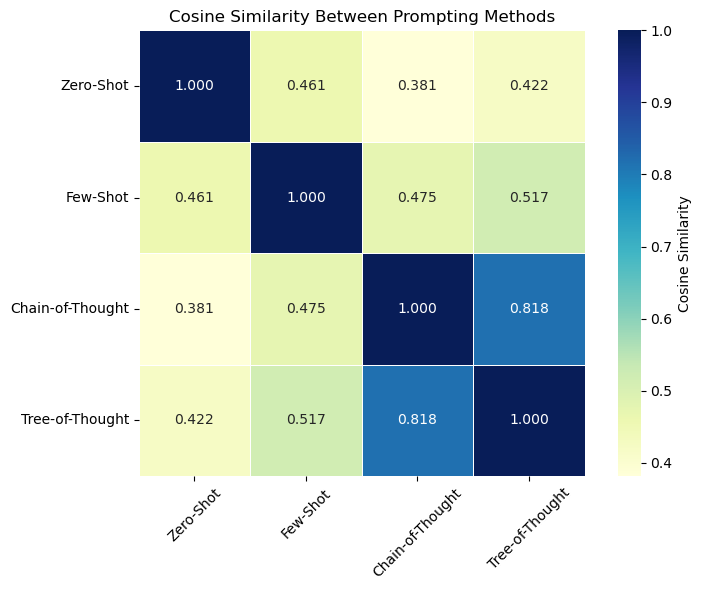

In [26]:
# Step 1: Create matrix from embeddings
embedding_matrix = np.stack([embeddings[label] for label in prompt_labels])

# Step 2: Compute cosine similarity
similarity_matrix = cosine_similarity(embedding_matrix)

# Step 3: Convert to DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=prompt_labels, columns=prompt_labels)
print("Cosine Similarity Matrix:\n")
print(similarity_df.round(3))

# Step 4: Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", fmt=".3f", square=True,
            linewidths=0.5, cbar_kws={'label': 'Cosine Similarity'})
plt.title("Cosine Similarity Between Prompting Methods")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


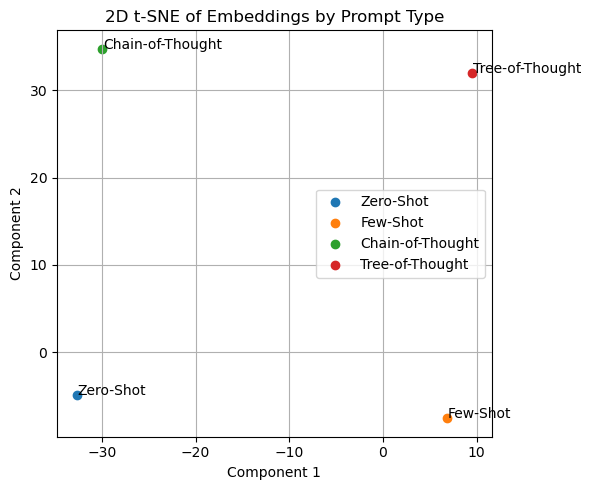

In [27]:
# Reduce to 2D
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
embeddings_2d = tsne.fit_transform(embedding_matrix)

# Plot
plt.figure(figsize=(6, 5))
for i, label in enumerate(prompt_labels):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], label=label)
    plt.text(embeddings_2d[i, 0]+0.1, embeddings_2d[i, 1], label, fontsize=10)

plt.title("2D t-SNE of Embeddings by Prompt Type")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import json

with open("prompt_embeddings.json", "w") as f:
    json.dump({k: v for k, v in embeddings.items()}, f, indent=2)


___
## Downstream Task: Clinical Note Urgency Classification

Beyond simplifying medical notes, this project extends the role of Large Language Models (LLMs) to perform **classification** — specifically, assessing the **urgency level** of a patient's condition. This simulates real-world clinical triage and demonstrates the utility of generative AI for structured medical decision support.

### Task Description:
The LLM classifies each simplified clinical note into one of three urgency levels:
- **High** – Requires immediate medical attention (e.g., low oxygen, chest pain)
- **Medium** – Requires timely follow-up or shows moderate concern (e.g., fatigue, elevated vitals)
- **Low** – Routine care or ongoing chronic condition management

### Prompting Strategy:
We use a structured **zero-shot prompt** where the LLM:
1. Reads the simplified version of the clinical note.
2. Outputs a formatted response with Urgency and Resaons

Responses are cached using the same mechanism as other prompting tasks to avoid unnecessary API calls.

### Evaluation:
- A set of ground truth urgency labels is manually specified.
- Predictions are evaluated using:
- **Accuracy**
- **Precision / Recall / F1 Score**
- Optional: Visualization of predicted urgency levels using bar charts

### Value of This Task:
- Demonstrates how LLMs can go **beyond text generation** to perform **actionable clinical reasoning**.
- Bridges generative capabilities with structured downstream tasks.
- Aligns with real-world healthcare applications such as **automated triage** and **clinical prioritization systems**.
- Fulfills **bonus credit** requirements of the assignment by implementing classification and evaluation.

In [29]:

# --- Prompt Template ---
def create_urgency_classification_prompt(note: str) -> str:
    return (
        "Given the simplified medical note below, classify the patient's urgency as one of the following:\n"
        "- High: Needs immediate medical attention\n"
        "- Medium: Needs timely follow-up\n"
        "- Low: Routine care or ongoing management\n\n"
        f"Simplified Note:\n{note}\n\n"
        "Return your answer in the format:\nUrgency: <High|Medium|Low>\nReason: <brief explanation>"
    )

# --- Load/Save JSON cache ---
classification_cache = load_json_cache(CLASSIFICATION_CACHE_PATH)

# --- Storage ---
classified_notes = []
predicted_urgency = []

# --- Process N notes ---
for i in range(N_CLASSIFY):
    note = build_note_from_patient_v2(
        patients.iloc[i]["Id"], patients, conditions, encounters, observations, medications
    )
    simplified_note = call_openai_with_prompt(create_zero_shot_prompt(note), client)

    prompt = create_urgency_classification_prompt(simplified_note)

    if prompt in classification_cache:
        response = classification_cache[prompt]
    else:
        if CALL_OPENAI_CLASSIFY:
            response = call_openai_with_prompt(prompt, client)
            classification_cache[prompt] = response
            save_json_cache(classification_cache, CLASSIFICATION_CACHE_PATH)
        else:
            response = "[Classification will appear here when CALL_OPENAI_CLASSIFY is True]"

    # Extract urgency label (simple regex or text parsing)
    urgency = None
    for line in response.splitlines():
        if line.lower().startswith("urgency:"):
            urgency = line.split(":")[1].strip().capitalize()
            break

    if urgency not in ["High", "Medium", "Low"]:
        urgency = "Unknown"
    print(response, urgency)

    classified_notes.append({
        "note": simplified_note,
        "response": response,
        "urgency": urgency
    })
    
    predicted_urgency.append(urgency)


**** Sending message to OpenAI ****

 Please simplify the following medical note so that a patient with no medical background can easily understand it:

Mr. Joshua658 Kunde533 is a 31 year-old married male. Patient is white, nonhispanic, from Massachusetts.
Medical history includes: Housing unsatisfactory (finding), Received higher education (finding), Transport problem (finding). Recent encounter: encounter for check up (procedure) on 2022-05-01. Key observation: qols = 1.0. Prescribed: Acetaminophen 325 MG Oral Tablet. 

 Token Usage:
  - Prompt tokens:  130
  - Output tokens:  95
  - Total tokens:   225
 Estimated Cost:
  - Input cost:     $0.000065
  - Output cost:    $0.000142
  - Total cost:     $0.000208

**** Sending message to OpenAI ****

 Given the simplified medical note below, classify the patient's urgency as one of the following:
- High: Needs immediate medical attention
- Medium: Needs timely follow-up
- Low: Routine care or ongoing management

Simplified Note:
Mr. Jos


Classification Report:
              precision    recall  f1-score   support

         Low      0.500     0.500     0.500         4
      Medium      0.667     0.667     0.667         6

    accuracy                          0.600        10
   macro avg      0.583     0.583     0.583        10
weighted avg      0.600     0.600     0.600        10

Accuracy: 0.60


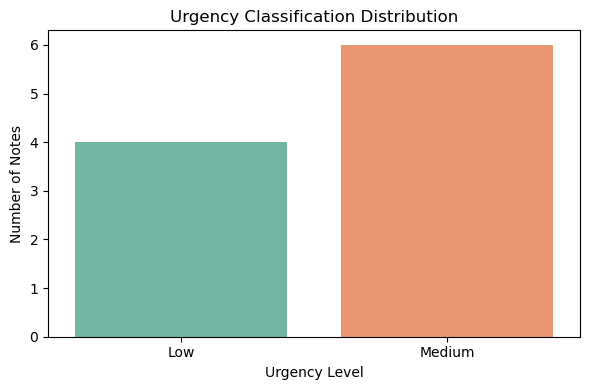

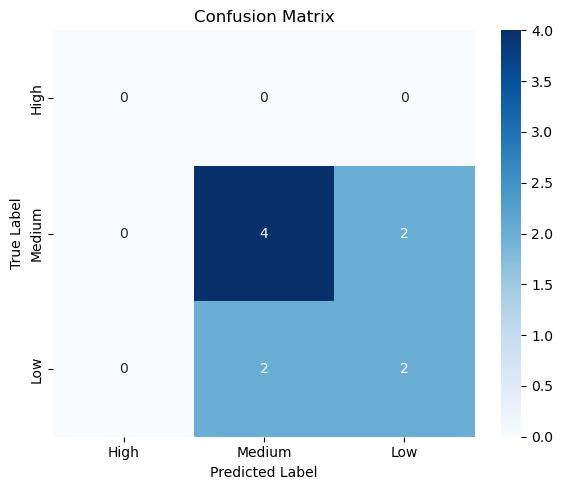

True Labels: ['Low', 'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Medium', 'Medium', 'Low', 'Medium']
Predicted: ['Low', 'Medium', 'Medium', 'Medium', 'Low', 'Medium', 'Medium', 'Low', 'Medium', 'Low']


In [30]:
# Use actual true labels
true_labels = ["Low", "Medium", "Medium", "Medium", "Low", "Low", "Medium", "Medium", "Low", "Medium"][:N_CLASSIFY]

print("\nClassification Report:")
print(classification_report(true_labels, predicted_urgency, digits=3))

accuracy = accuracy_score(true_labels, predicted_urgency)
print(f"Accuracy: {accuracy:.2f}")

#--- Visualize Distribution ---
label_counts = Counter(predicted_urgency)

plt.figure(figsize=(6, 4))
sns.barplot(x=list(label_counts.keys()), hue=list(label_counts.keys()),  y=list(label_counts.values()), palette="Set2")
plt.title("Urgency Classification Distribution")
plt.xlabel("Urgency Level")
plt.ylabel("Number of Notes")
plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
# You must have true_labels = ["High", "Low", "Medium", ...] with same length as predicted_urgency
conf_mat = confusion_matrix(true_labels, predicted_urgency, labels=["High", "Medium", "Low"])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=["High", "Medium", "Low"],
            yticklabels=["High", "Medium", "Low"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Build DataFrame
df_eval = pd.DataFrame({
    "True": true_labels,
    "Predicted": predicted_urgency
})
print("True Labels:", true_labels)
print("Predicted:", predicted_urgency)

In [31]:
zero_shot_output = zero_shot_cache.get(example_note, "N/A")
few_shot_output = fewshot_response
cot_output = cot_response
tot_output = tot_response


In [32]:
from IPython.display import display, HTML

df = pd.DataFrame({
    "Prompt Type": ["Zero-shot", "Few-shot", "Chain-of-Thought", "Tree-of-Thought"],
    "Simplified Output": [
        zero_shot_output,  # from cache or OpenAI
        few_shot_output,
        cot_response,
        tot_response
    ]
})


# Option 1: Using DataFrame styling (for Jupyter notebooks)
styled_df = df.style.set_properties(**{
    'text-align': 'left',  # Change to 'center', 'right', or 'justify' as needed
    'white-space': 'pre-wrap',
    'word-wrap': 'break-word',
    'max-width': '1000px'
})
display(styled_df)


,Prompt Type,Simplified Output
0,Zero-shot,"Mr. Alonzo487 Friesen796 is a 28-year-old man from Massachusetts. He is single and white. He has been involved in risky activities, has completed higher education, and works full-time. He recently had a check-up on November 3, 2024. His total score for alcohol use is 1.0. He was prescribed a medication called amlodipine 2.5 mg to take by mouth."
1,Few-shot,"Simplified Note: Mr. Stanton715 Kassulke119 is a 15-year-old boy from Massachusetts. His marital status is unknown. He is white and non-Hispanic. His medical history includes a bone fracture and an ankle fracture. He had a well-child visit on September 26, 2024, where his total score on the patient health questionnaire-9 for teens was 1.0. He was prescribed Penicillin V Potassium 250 mg to take by mouth."
2,Chain-of-Thought,"1. The patient, Mr. Alonzo Friesen, is a 28-year-old single male from Massachusetts. He has a medical history of being involved in risky activities, having received higher education, and being employed full-time. 2. These findings suggest that Mr. Friesen is active and educated, but also engages in activities that may pose a risk to his health. 3. During his recent check-up on November 3, 2024, Mr. Friesen had a total score of 1.0 on a screening tool called AUDIT-C. The doctor prescribed him a medication called amlodipine 2.5 mg oral tablet, which is commonly used to treat high blood pressure. In simple terms: Mr. Friesen is a young man who recently had a check-up. The doctor found that he may be at risk for high blood pressure and prescribed him a medication to help manage it."
3,Tree-of-Thought,"1. Mr. Alonzo487 Friesen796 is a 28-year-old single man from Massachusetts. He has a history of engaging in risky activities, has received higher education, and works full-time. He recently had a check-up where his total score on a test was 1.0. He was prescribed a medication called amlodipine. 2. A 28-year-old man named Mr. Alonzo487 Friesen796 from Massachusetts came in for a check-up. He has a history of risky behavior, higher education, and works full-time. His test score was 1.0, and he was given a medication called amlodipine. 3. Mr. Alonzo487 Friesen796, who is a 28-year-old single man from Massachusetts, had a recent check-up. He has a history of risky activities, received higher education, and is employed full-time. His test score was 1.0, and he was prescribed a medication called amlodipine. The most clear and helpful simplification for the patient would be: **A 28-year-old man named Mr. Alonzo487 Friesen796 from Massachusetts had a recent check-up. He has a history of risky activities, higher education, and works full-time. His test score was 1.0, and he was given a medication called amlodipine.**"
